In [1]:
# Criação de graficos.
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt
# Manipulação de dados / álgebra linear.
import numpy as np
import pandas as pd
# Utilidades.
from sklearn.preprocessing import scale
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score
# Algoritmos de ML
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
# Outros
import warnings

In [2]:
# Algumas configurações.
%matplotlib inline
sns.set_style("darkgrid")
warnings.filterwarnings("ignore")
plt.rc("font", family="serif", size=15)

In [3]:
telemetry = pd.read_csv('PdM_telemetry.csv', error_bad_lines=False)
errors = pd.read_csv('PdM_errors.csv', error_bad_lines=False)
maint = pd.read_csv('PdM_maint.csv', error_bad_lines=False)
failures = pd.read_csv('PdM_failures.csv', error_bad_lines=False)
machines = pd.read_csv('PdM_machines.csv', error_bad_lines=False)

In [4]:
telemetry.head()

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511


In [5]:
telemetry.tail()

,datetime,machineID,volt,rotate,pressure,vibration
876095,2016-01-01 02:00:00,100,179.438162,395.222827,102.290715,50.771941
876096,2016-01-01 03:00:00,100,189.617555,446.207972,98.180607,35.123072
876097,2016-01-01 04:00:00,100,192.483414,447.816524,94.132837,48.314561
876098,2016-01-01 05:00:00,100,165.475310,413.771670,104.081073,44.835259
876099,2016-01-01 06:00:00,100,171.336037,496.096870,79.095538,37.845245


In [6]:
telemetry.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 876100 entries, 0 to 876099
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   datetime   876100 non-null  object 
 1   machineID  876100 non-null  int64  
 2   volt       876100 non-null  float64
 3   rotate     876100 non-null  float64
 4   pressure   876100 non-null  float64
 5   vibration  876100 non-null  float64
dtypes: float64(4), int64(1), object(1)
memory usage: 40.1+ MB


In [7]:
telemetry.dtypes

datetime      object
machineID      int64
volt         float64
rotate       float64
pressure     float64
vibration    float64
dtype: object

In [8]:
telemetry["machineID"].nunique()

100

In [9]:
# Trocamos o formato de datetime já que vem como string.
telemetry["datetime"] = pd.to_datetime(telemetry["datetime"], format="%Y-%m-%d %H:%M:%S")
telemetry.head()

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511


In [10]:
# A dtype de esta serie é objeto porque tem tipos misturados
telemetry.dtypes

datetime     datetime64[ns]
machineID             int64
volt                float64
rotate              float64
pressure            float64
vibration           float64
dtype: object

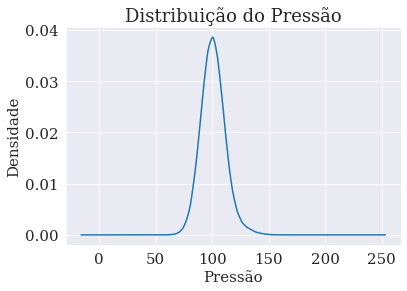

In [11]:
telemetry["pressure"].plot(kind="kde")
plt.title("Distribuição do Pressão")
plt.ylabel("Densidade")
plt.xlabel("Pressão")
plt.show()

In [12]:
# Confirmamos integridade; total, média, desvio padrão, mínimo, máximo, e quantil.
telemetry.describe()

,machineID,volt,rotate,pressure,vibration
count,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000
mean,50.500000,170.777736,446.605119,100.858668,40.385007
std,28.866087,15.509114,52.673886,11.048679,5.370361
min,1.000000,97.333604,138.432075,51.237106,14.877054
25%,25.750000,160.304927,412.305714,93.498181,36.777299
50%,50.500000,170.607338,447.558150,100.425559,40.237247
75%,75.250000,181.004493,482.176600,107.555231,43.784938
max,100.000000,255.124717,695.020984,185.951998,76.791072


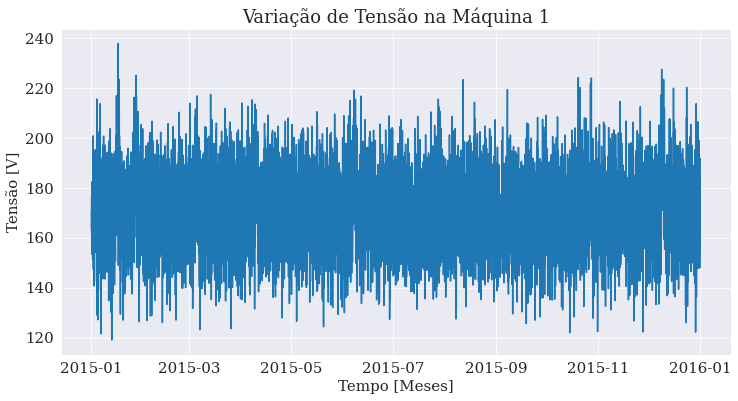

In [13]:
# Mostramos um gráfico de exemplo dos valores de voltagem para a máquina 1 durante os primeros 6 meses de 2015.

plot_df = telemetry.loc[
    (telemetry["machineID"] == 1)
    & (telemetry["datetime"] > pd.to_datetime("2015-01-01"))
    & (telemetry["datetime"] < pd.to_datetime("2016-12-01")), ["datetime", "volt"]
]

plt.figure(figsize=(12, 6))
plt.plot(plot_df["datetime"], plot_df["volt"])
plt.title("Variação de Tensão na Máquina 1")
plt.ylabel("Tensão [V]")

# Fazemos legível as etiquetas.
adf = plt.gca().get_xaxis().get_major_formatter()
adf.scaled[1.0] = "%m-%d"
plt.xlabel("Tempo [Meses]")
plt.show()

In [14]:
errors.head()

,datetime,machineID,errorID
0,2015-01-03 07:00:00,1,error1
1,2015-01-03 20:00:00,1,error3
2,2015-01-04 06:00:00,1,error5
3,2015-01-10 15:00:00,1,error4
4,2015-01-22 10:00:00,1,error4


In [15]:
errors.tail()

,datetime,machineID,errorID
3914,2015-11-21 08:00:00,100,error2
3915,2015-12-04 02:00:00,100,error1
3916,2015-12-08 06:00:00,100,error2
3917,2015-12-08 06:00:00,100,error3
3918,2015-12-22 03:00:00,100,error3


In [16]:
errors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3919 entries, 0 to 3918
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   datetime   3919 non-null   object
 1   machineID  3919 non-null   int64 
 2   errorID    3919 non-null   object
dtypes: int64(1), object(2)
memory usage: 92.0+ KB


In [17]:
# Formatando o campo de data e hora que vem como uma string.
# As categorias permiten a comparação entre valores, ordenamento automático, graficado mais simples e outras funções.
# Também menos memoria (similar a "factor" em R).
errors["datetime"] = pd.to_datetime(errors["datetime"], format="%Y-%m-%d %H:%M:%S")
errors["errorID"] = errors["errorID"].astype("category")

errors.head()

,datetime,machineID,errorID
0,2015-01-03 07:00:00,1,error1
1,2015-01-03 20:00:00,1,error3
2,2015-01-04 06:00:00,1,error5
3,2015-01-10 15:00:00,1,error4
4,2015-01-22 10:00:00,1,error4


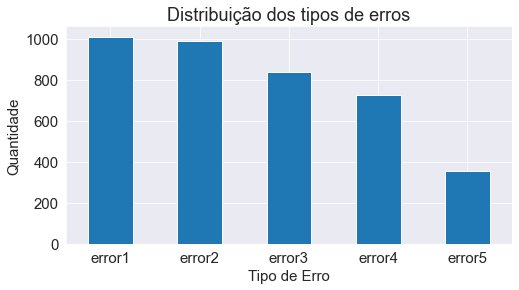

In [18]:
sns.set_style("darkgrid")
plt.figure(figsize=(8, 4))
errors["errorID"].value_counts().plot(kind="bar", rot=0)
plt.title("Distribuição dos tipos de erros")
plt.ylabel("Quantidade")
plt.xlabel("Tipo de Erro")
plt.show()

In [19]:
maint.head()

,datetime,machineID,comp
0,2014-06-01 06:00:00,1,comp2
1,2014-07-16 06:00:00,1,comp4
2,2014-07-31 06:00:00,1,comp3
3,2014-12-13 06:00:00,1,comp1
4,2015-01-05 06:00:00,1,comp4


In [20]:
maint.tail()

,datetime,machineID,comp
3281,2015-10-10 06:00:00,100,comp3
3282,2015-10-25 06:00:00,100,comp4
3283,2015-11-09 06:00:00,100,comp4
3284,2015-12-09 06:00:00,100,comp2
3285,2015-12-24 06:00:00,100,comp2


In [21]:
# Formatação do campo de data e hora que vem como string.
maint["datetime"] = pd.to_datetime(maint["datetime"], format="%Y-%m-%d %H:%M:%S")
maint["comp"] = maint["comp"].astype("category")
maint.dtypes

datetime     datetime64[ns]
machineID             int64
comp               category
dtype: object

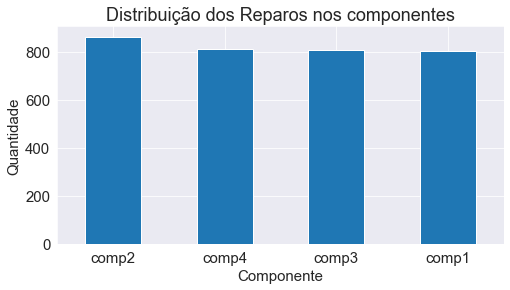

In [22]:
sns.set_style("darkgrid")
plt.figure(figsize=(8, 4))
maint["comp"].value_counts().plot(kind="bar", rot=0)
plt.title("Distribuição dos Reparos nos componentes")
plt.ylabel("Quantidade")
plt.xlabel("Componente")
plt.show()

In [23]:
machines.head()

,machineID,model,age
0,1,model3,18
1,2,model4,7
2,3,model3,8
3,4,model3,7
4,5,model3,2


In [24]:
machines.tail()

,machineID,model,age
95,96,model2,10
96,97,model2,14
97,98,model2,20
98,99,model1,14
99,100,model4,5


In [25]:
machines.shape

(100, 3)

In [26]:
machines.dtypes

machineID     int64
model        object
age           int64
dtype: object

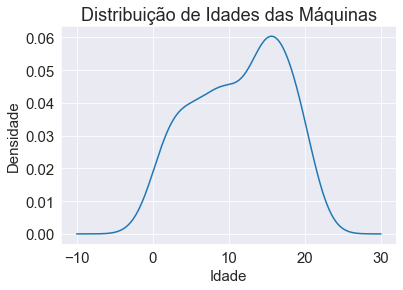

In [27]:
# Revisamos se existem varias colinas já que pode sugerir dos grupos diferentes.
machines["age"].plot(kind="kde")
plt.title("Distribuição de Idades das Máquinas")
plt.xlabel("Idade")
plt.ylabel("Densidade")
plt.show()

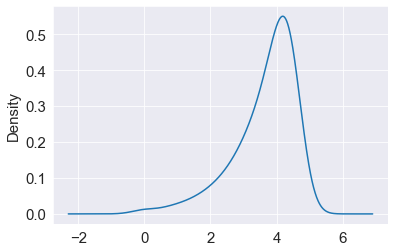

In [28]:
# Aplicamos logaritmo natural para normalizar.
np.log(machines[machines["age"] != 0].iloc[:, 0]).plot(kind="kde")
plt.show()

In [29]:
machines["model"] = machines["model"].astype("category")
machines.dtypes

machineID       int64
model        category
age             int64
dtype: object

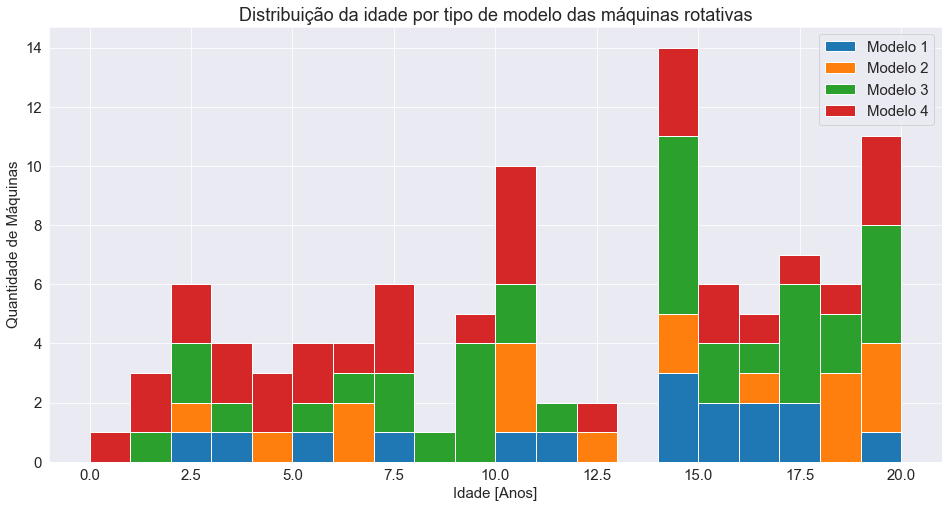

In [30]:
plt.figure(figsize=(16, 8))
_, bins, _ = plt.hist([
    machines.loc[machines["model"] == "model1", "age"],
    machines.loc[machines["model"] == "model2", "age"],
    machines.loc[machines["model"] == "model3", "age"],
    machines.loc[machines["model"] == "model4", "age"]],
    20, stacked=True, label=["Modelo 1", "Modelo 2", "Modelo 3", "Modelo 4"
])
plt.title("Distribuição da idade por tipo de modelo das máquinas rotativas")
plt.xlabel("Idade [Anos]")
plt.ylabel("Quantidade de Máquinas")
plt.legend()
plt.show()

In [31]:
failures.head()

,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4


In [32]:
failures.tail()

,datetime,machineID,failure
756,2015-11-29 06:00:00,99,comp3
757,2015-12-14 06:00:00,99,comp4
758,2015-02-12 06:00:00,100,comp1
759,2015-09-10 06:00:00,100,comp1
760,2015-12-09 06:00:00,100,comp2


In [33]:
# Formatamos a datetime que vem como string
failures["datetime"] = pd.to_datetime(failures["datetime"], format="%Y-%m-%d %H:%M:%S")
failures["failure"] = failures["failure"].astype("category")
failures.dtypes

datetime     datetime64[ns]
machineID             int64
failure            category
dtype: object

In [34]:
failures.describe(include="all")


,datetime,machineID,failure
count,761,761.000000,761
unique,302,NaN,4
top,2015-01-02 03:00:00,NaN,comp2
freq,18,NaN,259
first,2015-01-02 03:00:00,NaN,NaN
last,2015-12-31 06:00:00,NaN,NaN
mean,NaN,51.911958,NaN
std,NaN,29.515542,NaN
min,NaN,1.000000,NaN
25%,NaN,24.000000,NaN


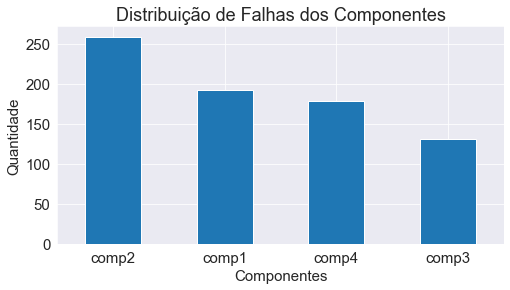

In [35]:
plt.figure(figsize=(8, 4))
failures["failure"].value_counts().plot(kind="bar", rot=0)
plt.title("Distribuição de Falhas dos Componentes")
plt.ylabel("Quantidade")
plt.xlabel("Componentes")
plt.show()

In [36]:
# Calculamos valores médio para características de telemetría

temp = []
fields = ["Tensão", "Rotação", "Pressão", "Vibração"]

# pivotamos porque necesitamos da datetime como índice para  que "redimensionamento" funcione
# Reamostrar cria lagging
# closed = 'right' => (6:00, 9:00] o 6:00 < x <= 9:00
# closed='left'  => [6:00, 9:00) o 6:00 <= x < 9:00
# Não podem ser ambos
# unstack: devolve df ao formato original
# temos 100 máquinas, 4 sensores = 400 colunas
# unstack mostra um dataseries as colunas como índice e voltar serie (se tem varios índices se reacomodan).
# Cada dataframe em temp tem os valores do campo que lhe corresponde neste momento.

temp = [
    pd.pivot_table(
        telemetry,
        index="datetime",
        columns="machineID",
        values=col).resample("3H", closed="left", label="right").mean().unstack()
    for col in fields
]
temp[0].head()

KeyError: 'Tensão'

In [ ]:
telemetry_mean_3h = pd.concat(temp, axis=1) # Unimos as series.
telemetry_mean_3h.columns = [col + "mean_3h" for col in fields] # Atribuímos nomes de colunas.
telemetry_mean_3h.reset_index(inplace=True) # Nivelamos o frame.
telemetry_mean_3h.head()

In [ ]:
# Repetimos para a desvio padrão.
temp = [
    pd.pivot_table(
        telemetry,
        index="datetime",
        columns="machineID",
        values=col).resample("3H", closed="left", label="right").std().unstack()
    for col in fields
]
temp[0].head()

In [ ]:
telemetry_sd_3h = pd.concat(temp, axis=1)
telemetry_sd_3h.columns = [i + "sd_3h" for i in fields]
telemetry_sd_3h.reset_index(inplace=True)
telemetry_sd_3h.head()

In [ ]:
# Para capturar um efeito a longo prazo, as funções de lagging de 24 horas também precisam ser calculadas.
# Criamos novos valores com médias de 24 horas, e logo selecionamos o primeiro resultado cada 3 horas.
# Desta maneira podemos unir os resultados com as características de lagging anteriores (calculadas a 3 horas).

temp = []
fields = ["volt", "rotate", "pressure", "vibration"]

temp = [
    pd.pivot_table(
        telemetry,
        index="datetime",
        columns="machineID",
        values=col).rolling(window=24).mean().resample("3H", closed="left", label="right").first().unstack()
    for col in fields
]
temp[0].head()

In [ ]:
telemetry_mean_24h = pd.concat(temp, axis=1)
telemetry_mean_24h.columns = [i + "mean_24h" for i in fields]
telemetry_mean_24h.reset_index(inplace=True)
# Devido ao método da media móvel, os primeiros 23 registros são nulos; tem que eliminá-los.
# Não ocorre ao final do frame porque rolling termina no final.
# Terminamos com um frame de menos datos que o original de telemetría assim como o anterior de 3H.
telemetry_mean_24h = telemetry_mean_24h.loc[-telemetry_mean_24h["voltmean_24h"].isnull()]

In [ ]:
telemetry_mean_24h.head()

In [ ]:
# Repetimos para a desvio padrão.
temp = []
fields = ["volt", "rotate", "pressure", "vibration"]

temp = [
    pd.pivot_table(
        telemetry,
        index="datetime",
        columns="machineID",
        values=col).rolling(window=24).std().resample("3H", closed="left", label="right").first().unstack(level=-1)
    for col in fields
]
temp[0].head()

In [ ]:
telemetry_sd_24h = pd.concat(temp, axis=1)
telemetry_sd_24h.columns = [i + "sd_24h" for i in fields]
telemetry_sd_24h.reset_index(inplace=True)
telemetry_sd_24h = telemetry_sd_24h.loc[-telemetry_sd_24h["voltsd_24h"].isnull()]

In [ ]:
telemetry_sd_24h.head(10)

In [ ]:
# Juntamos as características criadas até agora.
# Tomamos os valores 2:6 para evitar ID e datas duplicadas.
# axis=0 nos movemos em direção as filas, axis=1, nos movemos em direção das columnas.
telemetry_feat = pd.concat([
    telemetry_mean_3h,
    telemetry_sd_3h.iloc[:, 2:6],
    telemetry_mean_24h.iloc[:, 2:6],
    telemetry_sd_24h.iloc[:, 2:6]], axis=1).dropna()
telemetry_feat.head()

In [ ]:
telemetry_feat.describe()

In [ ]:
"""
Começamos reformatando os dados de erro para ter uma entrada por máquina por vez
quando pelo menos um erro ocorreu.
Criamos uma coluna para cada tipo de erro.
"""
error_count = pd.get_dummies(errors) # Colocamos um 1 se o error aparece para esta máquina, 0 se for ao contrario.
error_count.columns = ["datetime", "machineID", "error1", "error2", "error3", "error4", "error5"]
error_count.head(15)

In [ ]:
"""
As datas no dataframe são repetidas, portanto, agrupamos por data.
Combinamos erros para uma determinada máquina em um momento específico.
Somamos caso haja vários erros do mesmo tipo ao mesmo tempo, mas não esperados.
"""
error_count_grouped = error_count.groupby(["machineID", "datetime"]).sum().reset_index()
error_count_grouped.head(15)

In [ ]:
"""
Verificamos se os erros registrados existem nas máquinas disponíveis preenchidas com 0
as não correspondências, portanto, procuramos apenas uma correspondência com datetime e machineID.
"""
error_count_filtered = telemetry[["datetime", "machineID"]].merge(
    error_count_grouped,
    on=["machineID", "datetime"],
    how="left"
).fillna(0.0)

error_count_filtered.head()

In [ ]:
# Revisamos que nao existem anomalías.
error_count_filtered.describe()

In [ ]:
# Calculamos a quantidade total de erros para cada tipo de error durante lapsos de 24 horas. 
# Tomaremos pontos cada 3 horas.

temp = []
fields = [
    "error%d" % i
    for i in range(1,6)
]

temp = [
    pd.pivot_table(
        error_count_filtered,
        index="datetime",
        columns="machineID",
        values=col).rolling(window=24).sum().resample("3H", closed="left", label="right").first().unstack()
    for col in fields
]
temp[0].head(10)

In [ ]:
error_count_total = pd.concat(temp, axis=1)
error_count_total.columns = [i + "count" for i in fields]
error_count_total.reset_index(inplace=True)
error_count_total = error_count_total.dropna()
error_count_total.head()

In [ ]:
error_count_total["error5count"].unique()

In [ ]:
maint.head()

In [ ]:
# Criamos uma coluna para cada tipo de error
comp_rep = pd.get_dummies(maint)
comp_rep.columns = ["datetime", "machineID", "comp1", "comp2", "comp3", "comp4"]
comp_rep.head()

In [ ]:
# Combinamos reparação para uma certa máquina em certo momento.
# Se nao agrupamos por data podemos ver outra perspectiva.
# Descobrimos que componenetes falham juntos, já que agrupamos por data.
comp_rep = comp_rep.groupby(["machineID", "datetime"]).sum().reset_index()
comp_rep.head()

In [ ]:
# Tem que agregar os tempos aonde nao houve substituições.
comp_rep = telemetry[["datetime", "machineID"]].merge(
    comp_rep,
    on=["datetime", "machineID"],
    how="outer").fillna(0).sort_values(by=["machineID", "datetime"]
)
comp_rep.head()

In [ ]:
components = ["comp1", "comp2", "comp3", "comp4"]
for comp in components:
    # Queremos obter a data da troca de componente mais recente.
    comp_rep.loc[comp_rep[comp] < 1, comp] = None 
    # As datas das entradas que se tem substituições.
    comp_rep.loc[-comp_rep[comp].isnull(), comp] = comp_rep.loc[-comp_rep[comp].isnull(), "datetime"]
    # Fazemos um forward-fill das datas mais recentes de uma troca de componente.
    # Preenchemos com o último valor válido encontrado top-bottom.
    comp_rep[comp] = pd.to_datetime(comp_rep[comp].fillna(method="ffill"))

# eliminamos amostras de 2014, podiam ter nulos, as manutenções começarão este ano.
comp_rep = comp_rep.loc[comp_rep["datetime"] > pd.to_datetime("2015-01-01")]
comp_rep.head(50)

In [ ]:
# Nós substituímos as datas mais recentes de troca pela quantidade de dias desde a troca mais recente.
for comp in components: comp_rep[comp] = (comp_rep["datetime"] - pd.to_datetime(comp_rep[comp])) / np.timedelta64(1, "D")
comp_rep.head()

In [ ]:
comp_rep.describe()

In [ ]:
# Finalmente unimos todas as características criadas.
final_feat = telemetry_feat.merge(error_count_total, on=["datetime", "machineID"], how="left")
final_feat = final_feat.merge(comp_rep, on=["datetime", "machineID"], how="left")
final_feat = final_feat.merge(machines, on=["machineID"], how="left")
final_feat.head()

In [ ]:
final_feat.describe()


In [ ]:
final_feat.head()


In [ ]:
"""
Estamos dizendo ao modelo que quaisquer valores semelhantes aos da janela de 24 horas
é uma falha desse componente, por isso as máquinas se repetem.
Usamos limite = 7 porque temos separações de 3 horas; 8 * 3 = 24 horas
mas levamos em consideração o primeiro valor não nulo, então é 7.
"""
labeled_features = final_feat.merge(failures, on=["datetime", "machineID"], how="left")
# Aplicamos um backward-fill de até 24h.
# fillna não funciona com tipos categóricos por agora (como a nova categoria se encaixaria? talvez).
# Passamos o object o string, aplicamos a operação, e regresamos a categoría.
labeled_features["failure"] = labeled_features["failure"].astype(object).fillna(method="bfill", limit=7)
labeled_features["failure"] = labeled_features["failure"].fillna("none")
labeled_features["failure"] = labeled_features["failure"].astype("category")
labeled_features.head()

In [ ]:
model_dummies = pd.get_dummies(labeled_features["model"])
labeled_features = pd.concat([labeled_features, model_dummies], axis=1)
labeled_features.drop("model", axis=1, inplace=True)


In [ ]:
labeled_features.head()

In [ ]:
# É necesario eliminar as variáveis com alta correlação (só uma), considerar > 70%.
f, ax = plt.subplots(figsize=(10, 8))
corr = labeled_features.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.title("Correlação Entre Variaveis")
plt.show()

In [ ]:
# Guardamos para aplicar otimização de hiper-parámetros.
labeled_features.to_pickle("final_datset.pickle")

In [ ]:
# Validação Cruzada
# Definido tempo para dataset de Treinamento/Teste.
threshold_dates =    [
    pd.to_datetime("2015-12-30 01:00:00"), 
    pd.to_datetime("2015-10-01 01:00:00")
                    ]

In [ ]:
test_results = []
models = []
total = len(threshold_dates)

# Divisão dos dados.
last_train_date = threshold_dates[0]
first_test_date = threshold_dates[1]

In [ ]:
# Teste é utilizado entre 20% e 30% dos dados.
ntraining = labeled_features.loc[labeled_features["datetime"] < last_train_date]
ntesting = labeled_features.loc[labeled_features["datetime"] > first_test_date]
print(f"{ntraining.shape[0]} registros para treinamento.")
print(f"{ntesting.shape[0]} registros para teste.")
print(f"{ntesting.shape[0] / ntraining.shape[0] * 100:0.1f}% dos dados são utilizados para teste.")

In [ ]:
fails_train = ntraining[ntraining["failure"] != "none"].shape[0]
no_fails_train = ntraining[ntraining["failure"] == "none"].shape[0]
fails_test = ntesting[ntesting["failure"] != "none"].shape[0]
no_fails_test = ntesting[ntesting["failure"] == "none"].shape[0]

print(f"{fails_train / no_fails_train * 100:0.1f}% dos casos são falhas do dataset de treinamento.")
print(f"{fails_test / no_fails_test * 100:0.1f}% dos casos são falhas do dataset de teste.")

In [ ]:
# Nós atribuímos os valores correspondentes a treinamento e teste.
train_y = labeled_features.loc[labeled_features["datetime"] < last_train_date, "failure"]
train_X = labeled_features.loc[labeled_features["datetime"] < last_train_date].drop(["datetime",
                                                                                    "machineID",
                                                                                    "failure"], axis=1)
test_y = labeled_features.loc[labeled_features["datetime"] > first_test_date, "failure"]
test_X = labeled_features.loc[labeled_features["datetime"] > first_test_date].drop(["datetime",
                                                                                   "machineID",
                                                                                   "failure"], axis=1)

In [ ]:
# Algoritmo Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier as xgb

In [ ]:
# Treinamento do Modelo de Gradient Boosting
model = GradientBoostingClassifier(random_state=42)
model = xgb(n_jobs=-1)
model.fit(train_X, train_y);

In [ ]:
# Algoritmo Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection

In [ ]:
# Treinamento do modelo Random Forest
model = RandomForestClassifier(criterion='gini', 
                               n_estimators=10, 
                               n_jobs=-1, 
                               random_state=42, 
                               max_depth=10)
model.fit(train_X, train_y); 

In [ ]:
# Obtemos resultados sobre o set de provas.
test_result = pd.DataFrame(labeled_features.loc[labeled_features["datetime"] > first_test_date])
test_result["predicted_failure"] = model.predict(test_X)
test_results.append(test_result)
models.append(model)

In [ ]:
# Abaixo, nós plotamos as importâncias do recurso no (primeiro) trained model
plt.figure(figsize=(10, 10))
labels, importances = zip(*sorted(zip(test_X.columns, models[0].feature_importances_), reverse=False, key=lambda x: x[1]))
plt.yticks(range(len(labels)), labels)
_, labels = plt.xticks()
plt.setp(labels, rotation=0)
plt.barh(range(len(importances)), importances)
plt.ylabel("Características")
plt.xlabel("Importancia (%)")
plt.title("Importancias das Características de Acordo com o Modelo")
plt.show()


In [ ]:
# Há um desbalance esperado.
plt.figure(figsize=(8, 4))
labeled_features["failure"].value_counts().plot(kind="bar", rot=0)
plt.title("Distribuiçãi de Causas de Falhas")
plt.xlabel("Componente")
plt.ylabel("Quantidade")
plt.show()

In [ ]:
def Evaluate(predicted, actual, labels):
    output_labels = []
    output = []
    
    # Calcular a Matriz Confusão
    cm = confusion_matrix(actual, predicted, labels=labels)
   
    # Calcular precisão, recall, and F1 score
    accuracy = np.array([float(np.trace(cm)) / np.sum(cm)] * len(labels))
    precision = precision_score(actual, predicted, average=None, labels=labels)
    recall = recall_score(actual, predicted, average=None, labels=labels)
    f1 = 2 * precision * recall / (precision + recall)
    output.extend([accuracy.tolist(), precision.tolist(), recall.tolist(), f1.tolist()])
    output_labels.extend(["accuracy", "precision", "recall", "F1"])
    
    # Calcular a macro verção dessas métricas
    output.extend([[np.mean(precision)] * len(labels),
                   [np.mean(recall)] * len(labels),
                   [np.mean(f1)] * len(labels)])
    output_labels.extend(["macro precision", "macro recall", "macro F1"])
    
    # Achar o one-vs.-all complicação matrix
    cm_row_sums = cm.sum(axis = 1)
    cm_col_sums = cm.sum(axis = 0)
    s = np.zeros((2, 2))
    for i in range(len(labels)):
        v = np.array([[cm[i, i],
                       cm_row_sums[i] - cm[i, i]],
                      [cm_col_sums[i] - cm[i, i],
                       np.sum(cm) + cm[i, i] - (cm_row_sums[i] + cm_col_sums[i])]])
        s += v
    s_row_sums = s.sum(axis = 1)
    
    # Adicionar precição media e micro-averaged  precisão/recall/F1
    avg_accuracy = [np.trace(s) / np.sum(s)] * len(labels)
    micro_prf = [float(s[0,0]) / s_row_sums[0]] * len(labels)
    output.extend([avg_accuracy, micro_prf])
    output_labels.extend(["average accuracy",
                          "micro-averaged precision/recall/F1"])
    
    # Calcular métricas para o classificador majoritário.
    mc_index = np.where(cm_row_sums == np.max(cm_row_sums))[0][0]
    cm_row_dist = cm_row_sums / float(np.sum(cm))
    mc_accuracy = 0 * cm_row_dist; mc_accuracy[mc_index] = cm_row_dist[mc_index]
    mc_recall = 0 * cm_row_dist; mc_recall[mc_index] = 1
    mc_precision = 0 * cm_row_dist
    mc_precision[mc_index] = cm_row_dist[mc_index]
    mc_F1 = 0 * cm_row_dist;
    mc_F1[mc_index] = 2 * mc_precision[mc_index] / (mc_precision[mc_index] + 1)
    output.extend([mc_accuracy.tolist(), mc_recall.tolist(),
                   mc_precision.tolist(), mc_F1.tolist()])
    output_labels.extend(["majority class accuracy", "majority class recall",
                          "majority class precision", "majority class F1"])
        
    # Precisão aleatória e kappa
    cm_col_dist = cm_col_sums / float(np.sum(cm))
    exp_accuracy = np.array([np.sum(cm_row_dist * cm_col_dist)] * len(labels))
    kappa = (accuracy - exp_accuracy) / (1 - exp_accuracy)
    output.extend([exp_accuracy.tolist(), kappa.tolist()])
    output_labels.extend(["expected accuracy", "kappa"])
    

    # Palpite aleatório.
    rg_accuracy = np.ones(len(labels)) / float(len(labels))
    rg_precision = cm_row_dist
    rg_recall = np.ones(len(labels)) / float(len(labels))
    rg_F1 = 2 * cm_row_dist / (len(labels) * cm_row_dist + 1)
    output.extend([rg_accuracy.tolist(), rg_precision.tolist(),
                   rg_recall.tolist(), rg_F1.tolist()])
    output_labels.extend(["random guess accuracy", "random guess precision",
                          "random guess recall", "random guess F1"])
    
    # Suposição ponderada aleatória.
    rwg_accuracy = np.ones(len(labels)) * sum(cm_row_dist**2)
    rwg_precision = cm_row_dist
    rwg_recall = cm_row_dist
    rwg_F1 = cm_row_dist
    output.extend([rwg_accuracy.tolist(), rwg_precision.tolist(),
                   rwg_recall.tolist(), rwg_F1.tolist()])
    output_labels.extend(["random weighted guess accuracy",
                          "random weighted guess precision",
                          "random weighted guess recall",
                          "random weighted guess F1"])

    output_df = pd.DataFrame(output, columns=labels)
    output_df.index = output_labels
                  
    return output_df


In [ ]:
evaluation_results = []
test_result = test_results[0]
evaluation_result = Evaluate(actual = test_result["failure"],
                             predicted = test_result["predicted_failure"],
                             labels = ["none", "comp1", "comp2", "comp3", "comp4"])
skplt.metrics.plot_confusion_matrix(
    test_result["failure"],
    test_result["predicted_failure"],
    normalize=False,
    title="Matriz Confusão Gradient Boosting"
)

skplt.metrics.plot_confusion_matrix(
    test_result["failure"],
    test_result["predicted_failure"],
    normalize=True,
    title="Matriz Confusão Normatizada Gradient Boosting",
)
plt.show()

evaluation_results.append(evaluation_result)
evaluation_results[0]  # mostrar resultados completos apenas para a primeira divisão.

In [ ]:
# Para um problema de clasificação binaria se utiliza a curva ROC-AUC.
# Para este caso multi-clase utilizaremos precisão vs sensibilidade.
skplt.metrics.plot_precision_recall_curve(
    test_y,
    model.predict_proba(test_X),
    title="Curva Precisão-Sensibilidade",
    figsize=(10,3)
)
plt.show()

In [ ]:
evaluation_results[0].loc["recall"].values


In [ ]:
recall_df = pd.DataFrame([evaluation_results[0].loc["recall"].values],
                         columns=["none", "comp1", "comp2", "comp3", "comp4"],
                         index=["Sensibilidade por Componente"])
recall_df.T

In [ ]:
test_values = train_X.iloc[0].values
test_values

In [ ]:
# XGBoost aceita únicamente matrizes de 2 dimensões.
single_test = pd.DataFrame([test_values], columns=test_X.columns, index=[0])
single_test

In [ ]:
probas = model.predict_proba(single_test)
prediction = model.predict(single_test)
ordered_classes = np.unique(np.array(test_y))

In [ ]:
results = pd.DataFrame(probas,
                       columns=ordered_classes,
                       index=[0])
print(f"Predicción: {prediction[0]}")
results